Copied from Kaggle:

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

In [4]:
# Importing the libraries and datasets.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from sklearn.linear_model import LinearRegression
%matplotlib inline

train = pd.read_csv('~/datasets/bikeshare/train.csv')
test = pd.read_csv('~/datasets/bikeshare/test.csv')
wmata_delay=pd.read_csv('~/datasets/bikeshare/wmata_delay_wrangled.csv')
train.shape

(10886, 12)

In [3]:
# Let's take a look at the training data from Kaggle.

print(list(train))
print(train.dtypes)

['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


In [5]:
# The date/time stamp has good information, but not in this form.
# Let's extract the date from the hour to perform more extensive EDA.
# Also, lets extract the day of the week infromation from the date field.

# Separating the datetime field into separate date and time (hour) columns for train and test.
train["date"] = train.datetime.apply(lambda x : x.split()[0])
train["hour"] = train.datetime.apply(lambda x : x.split()[1].split(":")[0])

test["date"] = test.datetime.apply(lambda x : x.split()[0])
test["hour"] = test.datetime.apply(lambda x : x.split()[1].split(":")[0])

train.hour = train.hour.astype(int)
test.hour = test.hour.astype(int)

print(train.shape)
print(list(train))
print(train.dtypes)

print(test.shape)
print(list(test))
print(test.dtypes)

(10886, 14)
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'date', 'hour']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
date           object
hour            int32
dtype: object
(6493, 11)
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour']
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
date           object
hour            int32
dtype: object


In [6]:
# Merging in external data from DC Metro (WMATA).
# Let's see if transit delays/outages affect cycling ridership in our bikeshare data. 

#new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])
merged = pd.merge(train, wmata_delay, how='left', left_on=['date','hour'], right_on = ['date','hour'])
merged.drop_duplicates(['datetime'], keep='last')
print(merged.shape)
print(train.shape)
merged.to_csv('~/datasets/bikeshare/merge_test.csv', sep=',')

(10886, 20)
(10886, 14)


In [9]:
# Let's see the first few rows of the datasets.

print('Training data - first five rows.')
print(train[:5]) # Printing the first 5 rows just to see the data.
print('_____________________________________________________________________')
print('Test data - first five rows.')
print(test[:5])
print('_____________________________________________________________________')
print('Merged data - first five rows.')
print(merged[:5])

Training data - first five rows.
              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count        date  hour  
0        81        0.0       3          13     16  2011-01-01     0  
1        80        0.0       8          32     40  2011-01-01     1  
2        80        0.0       5          27     32  2011-01-01     2  
3        75        0.0       3          10     13  2011-01-01     3  
4        75        0.0       0           1      1  2011-01-01     4  
_____________________________________________________________________
Test dat

In [11]:
# To generate a baseline, we are calculating the average number of total riders per hour.

#  Calculate the hourly averages and save as "averages"
averages = train.groupby(['hour']).mean()

# Only save the appropriate columns
averages = averages.ix[:,'casual':]

# Renaming the index, and adding the hours column
averages.index.names = ['index']
hour = {'hour': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]}
df_hour = pd.DataFrame(hour, columns = ['hour'])
averages = pd.merge(averages, df_hour, right_index=True, left_index=True)

# Here is the dataset that calculated the average number of riders per hour, across all days.
print(averages)
print(averages.dtypes)

          casual  registered       count  hour
index                                         
0      10.312088   44.826374   55.138462     0
1       6.513216   27.345815   33.859031     1
2       4.819196   18.080357   22.899554     2
3       2.681293    9.076212   11.757506     3
4       1.262443    5.144796    6.407240     4
5       1.455752   18.311947   19.767699     5
6       4.149451   72.109890   76.259341     6
7      10.914286  202.202198  213.116484     7
8      21.542857  341.226374  362.769231     8
9      30.956044  190.824176  221.780220     9
10     46.118681  128.973626  175.092308    10
11     60.052747  150.621978  210.674725    11
12     68.831140  187.677632  256.508772    12
13     74.059211  183.728070  257.787281    13
14     76.589912  166.853070  243.442982    14
15     76.028509  178.269737  254.298246    15
16     75.083333  241.289474  316.372807    16
17     75.440789  393.324561  468.765351    17
18     61.396930  369.462719  430.859649    18
19     49.074

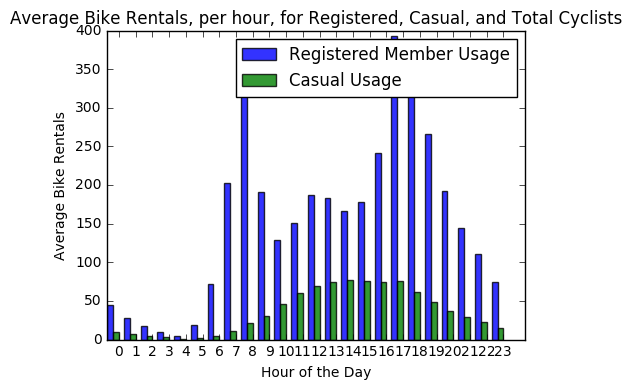

In [14]:
# Let's plot the data
n_groups = 24
casual = averages['casual']
registered = averages['registered']
 
# Create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, registered, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Registered Member Usage')
 
rects2 = plt.bar(index + bar_width, casual, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Casual Usage')
 
plt.xlabel('Hour of the Day')
plt.ylabel('Average Bike Rentals')
plt.title('Average Bike Rentals, per hour, for Registered, Casual, and Total Cyclists')
plt.xticks(index + 2*bar_width, index)
plt.legend()
 
plt.tight_layout()
plt.show()

In [15]:
# Now we need to join the test and average dataframes,
# to show the average numbers of riders per hour for each day.

submission = test.merge(averages, on='hour')
submission = submission.drop(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'date', 'hour', 'casual', 'registered'], axis=1)
submission = submission.set_index('datetime')
print(submission)

                         count
datetime                      
2011-01-20 00:00:00  55.138462
2011-01-21 00:00:00  55.138462
2011-01-22 00:00:00  55.138462
2011-01-23 00:00:00  55.138462
2011-01-24 00:00:00  55.138462
2011-01-25 00:00:00  55.138462
2011-01-26 00:00:00  55.138462
2011-01-28 00:00:00  55.138462
2011-01-29 00:00:00  55.138462
2011-01-30 00:00:00  55.138462
2011-01-31 00:00:00  55.138462
2011-02-20 00:00:00  55.138462
2011-02-21 00:00:00  55.138462
2011-02-23 00:00:00  55.138462
2011-02-24 00:00:00  55.138462
2011-02-25 00:00:00  55.138462
2011-02-26 00:00:00  55.138462
2011-02-27 00:00:00  55.138462
2011-02-28 00:00:00  55.138462
2011-03-20 00:00:00  55.138462
2011-03-21 00:00:00  55.138462
2011-03-22 00:00:00  55.138462
2011-03-23 00:00:00  55.138462
2011-03-24 00:00:00  55.138462
2011-03-25 00:00:00  55.138462
2011-03-26 00:00:00  55.138462
2011-03-27 00:00:00  55.138462
2011-03-28 00:00:00  55.138462
2011-03-29 00:00:00  55.138462
2011-03-30 00:00:00  55.138462
...     

In [16]:
# Printing to text file
# This is our baseline submission

submission.to_csv('~/datasets/bikeshare/average_usage_baseline.csv', sep=',')

next steps...create a regression model. 
Ideas:

Weekday/Weekend/Holiday - Extracting 'Day of Week' from datetime and see if there is a difference.
Hypothesis - Casual Riders will increase during the weekend due to recreational habits, and 
registered riders will decrease due to assumption that registered riders use bikes to commute.

Weather - Which of the weather factors affect rider numbers, if any?  

Season/Holiday - Which, if any, seasons affect rider numbers?  In DC, the nicest weather is spring and fall - is this
represented in the data?  Summer is very, very hot, so I would assume registered riders would use the service in the 
evening commute, and casual riders would increase in the spring/summer, since those are the heaviest tourist seasons.

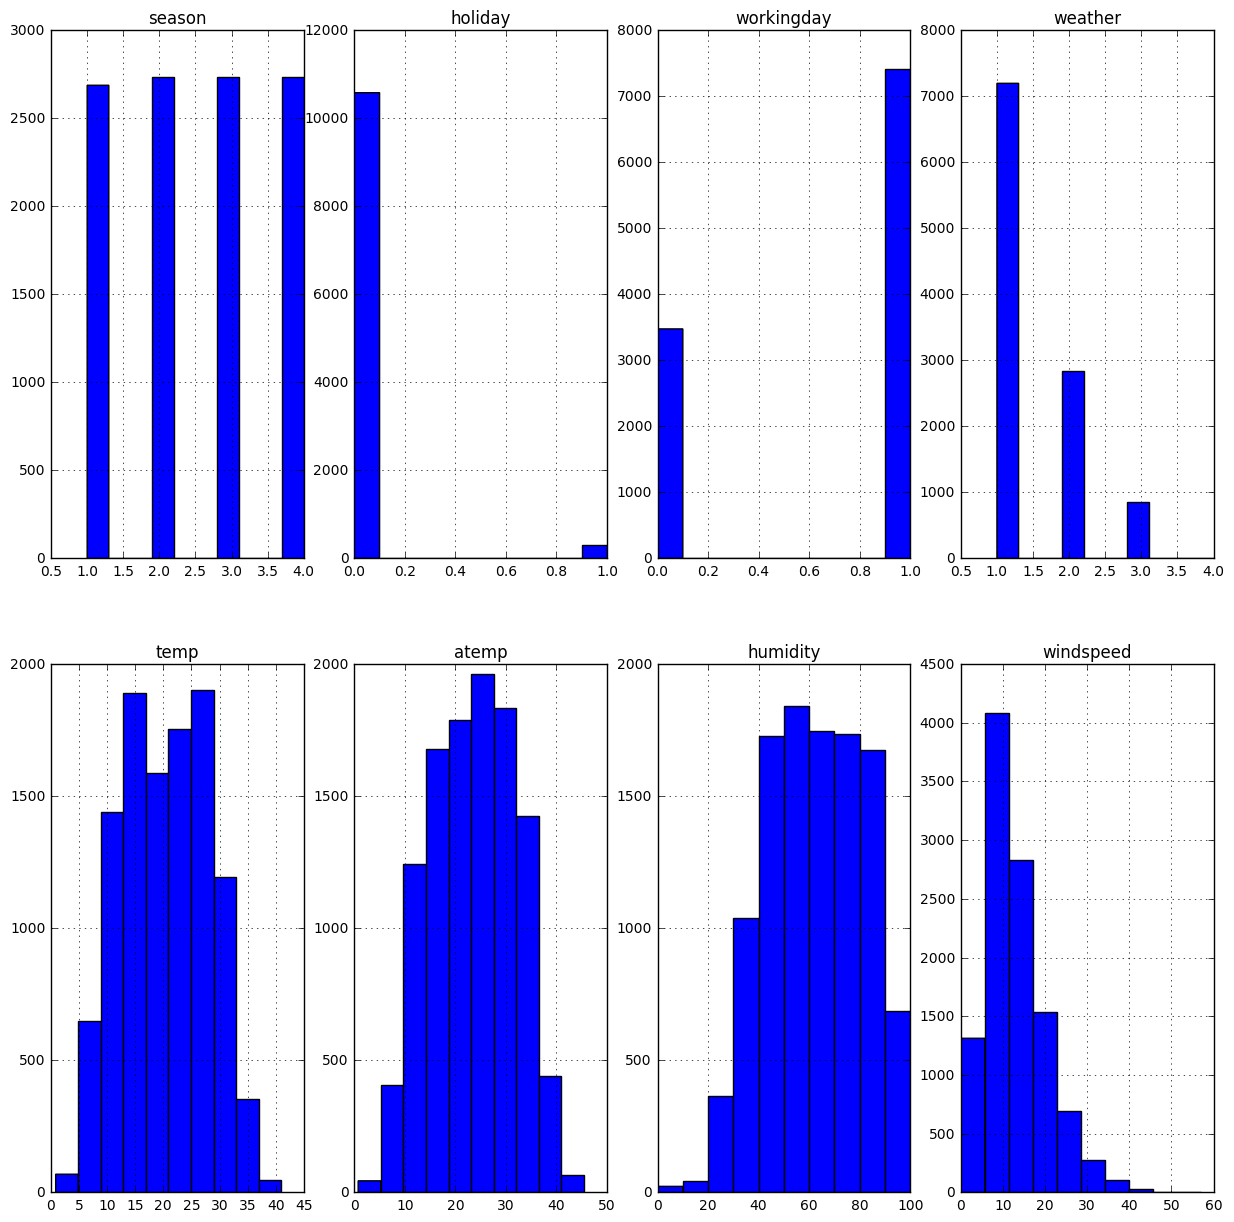

In [23]:
# Now, we need to figure out which variables affect ridership the most,
# thereby determining which factors are best to use for our model.
# Here are histograms of 8 different variables.

num_vars=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(15,15), dpi=150)
for i, var in enumerate(num_vars):
    j=i+1
    plt.subplot(2,4,j) 
    train[var].hist()
    plt.title(var)

The histograms reveal that season is almost equal distribution, weather type 1 (Clear, Few clouds, Partly cloudy, Partly cloudy) is dominant, atemp appears to be normally distributed with a peak riding temperate of about 25 degrees and windspeed appears to be inversely correlated with ridership.

In [33]:
# Keep this random seed here to make comparison easier.
np.random.seed(785)

# Dividing our training data into training and development sets.
msk = np.random.rand(len(train)) < 0.8
train_new = train[msk]
dev=train[~msk]
print ('Training set shape: ', train_new.shape)
print ('Dev set  shape: ', dev.shape)

Training set shape:  (8715, 14)
Dev set  shape:  (2171, 14)


In [31]:
#  What are the best variable(s) for registered cyclists?

registered_report=[]
for var in num_vars:
    X_train = train_new[var]
    X_dev = dev[var]

    Y_train = train_new['registered']
    Y_dev = dev['registered']

    X_train1=X_train.values.reshape(-1, 1)
    Y_train1=Y_train.values.reshape(-1, 1)
    Y_dev1=Y_dev.values.reshape(-1, 1)
    X_dev1=X_dev.values.reshape(-1, 1)


    # Create linear regression object
    #regr = linear_model.LinearRegression() (Jordan...I got an error doing this...)
    #So I modified to this... is this correct?  
    regr = LinearRegression()
    
    # Train the model using the training sets
    regr.fit(X_train1, Y_train1)
    preds = regr.predict(Y_dev1)

    # The coefficients
    #print('Coefficients: \n', regr.coef_[0][0])
    coef=regr.coef_[0][0]
    
    # The mean squared error
    #print("Mean squared error: %.2f"
         # % np.mean((preds) - Y_dev1) ** 2)
    mse=int(np.mean((preds) - Y_dev1) ** 2)
    
    # Explained variance score: 1 is perfect prediction
    #print('Variance score: %.2f' % regr.score(X_dev1, Y_dev1))
    var_score=regr.score(X_dev1, Y_dev1)
    registered_report.append([var, coef, mse, var_score])

print ("For registered cyclists:")
print ("Variable, coefficient, MSE, Variable score")
for i in registered_report:
    print( i)
print('_____________________________________________________________________')   
    
#  What are the best variable(s) for casual cyclists?

casual_report=[]
for var in num_vars:
    X_train = train_new[var]
    X_dev = dev[var]

    Y_train = train_new['casual']
    Y_dev = dev['casual']

    X_train1=X_train.values.reshape(-1, 1)
    Y_train1=Y_train.values.reshape(-1, 1)
    Y_dev1=Y_dev.values.reshape(-1, 1)
    X_dev1=X_dev.values.reshape(-1, 1)


    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train1, Y_train1)

    preds = regr.predict(Y_dev1)
    # The coefficients
    #print('Coefficients: \n', regr.coef_[0][0])
    coef=regr.coef_[0][0]
    # The mean squared error
    #print("Mean squared error: %.2f"
         # % np.mean((preds) - Y_dev1) ** 2)
    mse=int(np.mean((preds) - Y_dev1) ** 2)
    # Explained variance score: 1 is perfect prediction

    #print('Variance score: %.2f' % regr.score(X_dev1, Y_dev1))
    var_score=regr.score(X_dev1, Y_dev1)
    
    casual_report.append([var, coef, mse, var_score])

print ("For casual cyclists:")
print ("Variable, coefficient, MSE, Variable score")
for i in casual_report:
    print( i)

For registered cyclists:
Variable, coefficient, MSE, Variable score
['season', 22.346629555687997, 11810880, 0.026044630275451564]
['holiday', -19.039184998659231, 8862700, 0.00042761760039833341]
['workingday', 39.325073290646024, 37457871, 0.012359691610277057]
['weather', -24.167930005477306, 14026235, 0.01845181800144835]
['temp', 6.1295060692318355, 693818, 0.10875595788307968]
['atemp', 5.5356287821314147, 537581, 0.11027371954497277]
['humidity', -2.0848319580928605, 39193, 0.071878209711964791]
['windspeed', 1.7391023263732592, 61785, 0.0060854281445765768]
_____________________________________________________________________
For casual cyclists:
Variable, coefficient, MSE, Variable score
['season', 4.3438850570713967, 22404, 0.0073813127152221325]
['holiday', 11.957335128644457, 197612, 0.0019757421557516919]
['workingday', -33.232403847075147, 1488386, 0.10946339550393036]
['weather', -10.583710750707986, 145837, 0.017307608948005981]
['temp', 2.9583504949463855, 2382, 0.2143

We found that temperature is the most predictive basic feature for both registered and casual riders based on the variance score but this is not consistent with the mean square error.